In [1]:
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy import interpolate
import pickle

import os
import time

In [11]:
Ipath = "IforRealNeuron.csv"
Idat = np.genfromtxt(Ipath, delimiter=',')

#Ipath = "NaKL_stim_dt0p02_N6001.npy"
#Idat = np.load(Ipath)
#Idat[:,1] = Idat[:,1] - np.min(Idat[:,1])
#Idat[:,1] = np.multiply(Idat[:,1], 5 / np.max(Idat[:,1]))

In [5]:
#Scaling Values
# The scale for V * C should match the scale for I
V_scale = 1 # V to mV
C_scale = 1 # F to pF

# The scales for I * R should match the scale for V
I_scale = 1 # A to fA
R_scale = 1 # O to ...

In [6]:
# Voltages
# Chip bias voltage
V_ref = 1.0001 * V_scale
# Unit Volt(?) [kchl = mu/V_unit = 27.04994]
V_unit = 26e-3 * V_scale

# Currents
# Master current(?)
I_master = 8.208685e-9 * I_scale
# Voltage(?)
I_voltage = 184.6437 * I_scale
# Reference Current(?) [not updated?]
I_ref = 85e-9 * I_scale
# Injected current scale factor [KK = 0.01]
I_inj_scale = (0.01) * 1e-9 * I_scale

# Capacitances
# Membrane Capacitance [not updated?]
C_m = 4e-12 * C_scale
# Gate capacitance [not updated?]
C_gate = 5e-12 * C_scale

# Resistances [not updated?]
Res = 1.63e6 * R_scale
R_bias = 1.85e6  * R_scale
R_factor = 700e3 * R_scale
R_factor2 = 50e3 * R_scale

# Scale Factors [not updated?]
kappa = 0.7

# Maximum Conductances
g = np.array([(0.5304163+1)*200, (3.999987+1)*200, (1-0.8675566)*200])
# Reversal Potentials
E_rev = np.array([(2.237269+1)*200, (1-0.9999999)*200, (1+0.3125813)*200])

# Conductance Dynamics [not updated?]
vBias = np.zeros(7)
vHigh = V_ref + R_bias * I_voltage
vLow = V_ref - R_bias * I_voltage
I_factor = (vHigh - vLow) / R_factor
vBias[0] = vLow + I_factor * R_factor2

for i in xrange(1,7):
    #[635.2, 756.8, 878.42, 1000, 1121.57, 1243.14, 1364.7] in mV
    vBias[i] = vBias[i - 1] + I_factor * 2*R_factor2 
    
g_f = 1 / (C_gate * V_unit)


In [10]:
am = np.array([-0.7875065, -0.2145789, 0.005674724, 0.3692946, 3.999951, 1.55435, 2.299571])
bm = np.array([1.778074, 2.418419, 1.066007, 3.890062, -0.9999953, -0.9999945, -0.9999944])

ah = np.array([1.538206, 2.241685, 0.867281, -0.9998593, 1.452836, 1.554368, 2.214007])
bh = np.array([1.806145, 2.666627, 0.848876, -0.9998824, 1.311832, 0.6617278, 1.280923])

an = np.array([-0.9999999, -0.9999998, -0.9805707, -0.9999999, -0.9999991, -0.6520491, 0.6586263])
bn = np.array([1.494737, 0.4016247, -0.9976165, -1.0, -0.9999996, -0.9999873, -0.9791807])

### Save parameters for later use

In [12]:
model_params = []
model_params.append(g)
model_params.append(E_rev)
model_params.append(vBias)
model_params.append(am)
model_params.append(bm)
model_params.append(ah)
model_params.append(bh)
model_params.append(an)
model_params.append(bn)

with open("results/new_model_params.txt", "wb") as fp:
    pickle.dump(model_params ,fp)

scale_factors = np.array([V_scale, C_scale, I_scale, I_inj_scale, R_scale])
np.save('results/new_scale_factors.npy', scale_factors)

In [13]:
def sigma(vBiask, V, sign = 1):
    kchl = 27.04994
    return 1 / (1 + np.exp(sign * kchl * (vBiask - V)))



def alpha_spline(V, x, vBias=vBias, am=am, ah=ah, an=an):
    """
    Used to compute the conductance at each time point. 
    The optional arguments default to the parameters defined at the start of the document
    """
    alpha = 0
    for k in np.arange(7):
        if x == "m":
            alpha += am[k] * sigma(vBias[k], V, 1)
        if x == "h":
            alpha += ah[k] * sigma(vBias[k], V, -1)
        if x == "n":
            alpha += an[k] * sigma(vBias[k], V, 1)
    return alpha #* I_master / 1024 * g_f


def beta_spline(V, x, vBias=vBias, bm=bm, bh=bh, bn=bn):
    beta = 0
    for k in np.arange(7):
        if x == "m":
            beta += bm[k] * sigma(vBias[k], V, -1)
        if x == "h":
            beta += bh[k] * sigma(vBias[k], V, 1)
        if x == "n":
            beta += bn[k] * sigma(vBias[k], V, -1)
    return beta #* I_master / 1024 * g_f


Here we define our system as well as the injected current

In [23]:
fIdat = interpolate.interp1d(np.arange(0,len(Idat)), Idat) #Used to interpolate time points that are undefined in Idat
#fIdat = interpolate.interp1d(Idat[:,0], Idat[:,1]) #Used to interpolate time points that are undefined in Idat

I_sample=5e3
def I_inj(t, scale=I_inj_scale):
    if t * I_sample <= len(Idat):
        return fIdat(t * I_sample) * scale
    else:
        print("t is outside of interpolation range")
        return 0


def neuron(y, t):
    v, m, h, n = y

    I_na = g[0] * m**3 * h * (E_rev[0] - v)
    I_k = g[1] * n**4 * (E_rev[1] - v)
    I_l = g[2] * (E_rev[2] - v)
    
    dvdt = (I_inj(t) + I_na + I_l + I_k) / C_m
    dmdt = alpha_spline(v, "m") * (1 - m) - beta_spline(v, "m") * m
    dhdt = alpha_spline(v, "h") * (1 - h) - beta_spline(v, "h") * h
    dndt = alpha_spline(v, "n") * (1 - n) - beta_spline(v, "n") * n
    
    dydt = [dvdt, dmdt, dhdt, dndt]

    return dydt



def I_inj(t, scale=I_inj_scale):
    if t * 20 <= Idat[-1,0]:
        return fIdat(t * 20) * scale / 3
    else:
        return 0

We set the initial conditions and time window

In [24]:
y0 = [1.00 * V_scale, 0.5 * I_scale / (V_scale * C_scale), 
      0.5 * I_scale / (V_scale * C_scale), 0.5 * I_scale / (V_scale * C_scale)] #initial conditions
t_step = 1e-3
t_max = 4
t = np.linspace(0, t_max, int(t_max / t_step + 1))

start_time = time.time()

sol = odeint(neuron, y0, t, args=())
print "Time elapsed:", time.time() - start_time

Time elapsed: 33.6197271347


/usr/local/Cellar/ipython@5/5.5.0_1/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Plot the data

<IPython.core.display.Javascript object>


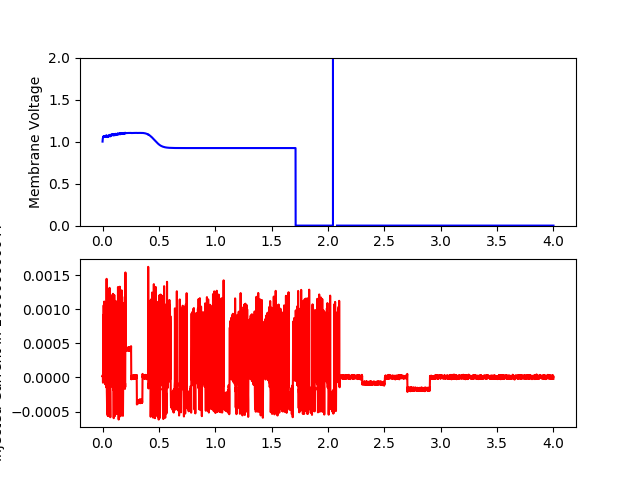

In [26]:
plt.subplot(2,1,1)
plt.plot(t, sol[:,0], 'b')
plt.ylabel('Membrane Voltage')
plt.ylim(0,2)

I_inj_v = np.vectorize(I_inj)
plt.subplot(2,1,2)
plt.plot(t, I_inj_v(t) * I_inj_scale, 'r')
plt.ylabel('Injected Current in %d A' % I_scale)

plt.show()

<IPython.core.display.Javascript object>


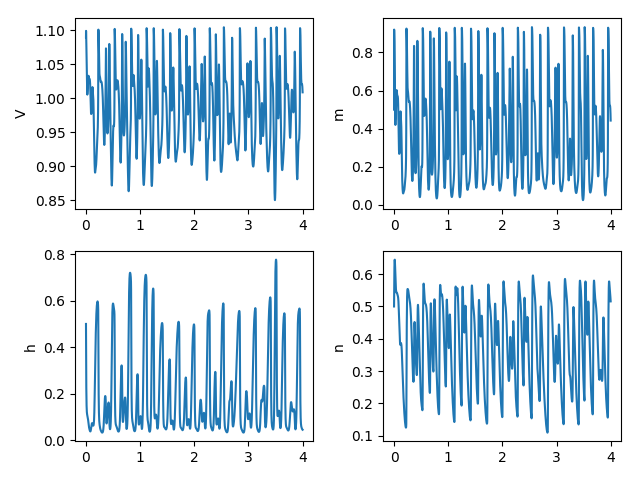

In [32]:
plt.subplot(2,2,1)
plt.plot(t, sol[:,0])
plt.ylabel("V")

plt.subplot(2,2,2)
plt.plot(t, sol[:,1])
plt.ylabel("m")

plt.subplot(2,2,3)
plt.plot(t, sol[:,2])
plt.ylabel("h")

plt.subplot(2,2,4)
plt.plot(t, sol[:,3])
plt.ylabel("n")

plt.tight_layout()
plt.show()

Save data

Truncate data

In [16]:
cutoff = int(0.125 * t_max / t_step)

In [183]:
# add time to data
data = np.insert(sol[0:cutoff,:], 0, t[0:cutoff], axis=1)
# add injected current at each time step to data
data = np.insert(data, data.shape[1], fIdat(t[0:cutoff] * I_sample), axis=1)
# change shape such that time steps are rows
data = data.reshape(len(t[0:cutoff]),6)
#np.save('ode_data.npy', data)



In [18]:
len(fIdat(t[0:cutoff]*I_sample))

500

In [17]:
np.savetxt('voltage_measured.dat', sol[0:cutoff,0])
np.savetxt('m_measured.dat', sol[0:cutoff,1])
np.savetxt('h_measured.dat', sol[0:cutoff,2])
np.savetxt('n_measured.dat', sol[0:cutoff,3])
np.savetxt('current.dat', fIdat(t[0:cutoff]*I_sample))